In [50]:
# imports
import pickle
import numpy as np
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
from torch import nn
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode import EEGClassifier
from braindecode.datautil.preprocess import zscore
from braindecode.samplers.ssl import RelativePositioningSampler

import relative_positioning as rp
import contrastive_net as cn

from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import helper_funcs as hf


# ----

from skorch.utils import to_tensor

In [33]:

# constants
random_state = 87
n_jobs = 1
window_size_s = 30
sfreq = 100

# define pre-training dataset
dataset = SleepPhysionet(
    subject_ids=[0,1,2,3,4,5],
    recording_ids=[1]
)


# sample data for which we are trying to generate predictions of the input data using a part of the SSL pre-trained model
path_to_sample = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_ssl_thesis/sleep_staging_dataset/"

# input test
X = mne.io.read_raw_fif(path_to_sample+"0-raw.fif")

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data

In [34]:
# dataset involves mutliple datasets - different subjects
print(len(dataset.datasets[0]))
print(len(X))

X.datasets = X
print(len(X.datasets))

2508001
2508001
2508001


In [35]:
# preprocessing

preprocessors = [
    Preprocessor(lambda x: x * 1e6),
    Preprocessor('filter', l_freq=None, h_freq=30, n_jobs=n_jobs)
]
preprocess(dataset, preprocessors)


# Create windows
window_size_samples = window_size_s * sfreq

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

# define windows
windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

# preprocess chanel-wise normalization
preprocess(windows_dataset, [Preprocessor(zscore)])


Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...


/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_ssl_thesis/braindecode/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3060000  =      0.000 

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
# from braindecode.datautil.preprocess import preprocess_raw

### input test

# preprocess(X, preprocessors)
# X_windows_dataset = create_windows_from_events(
#     X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
#     window_size_samples=window_size_samples,
#     window_stride_samples=window_size_samples, preload=True, mapping=mapping)
# preprocess(X_windows_dataset, [Preprocessor(zscore)])

X = SleepPhysionet(
    subject_ids=[0],
    recording_ids=[1]
)
X_windowed = create_windows_from_events(
    X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...
0 bad epochs dropped


In [37]:
# Splitting train, valid, test sets

subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = rp.RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

In [38]:
# Sampling
# these samplers will be used to create sample data from the training set for the SSL model

tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)

n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)

valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()

test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()


In [39]:
# Create model

# enable CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("CUDA enabled")
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=emb_size,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

model = cn.ContrastiveNet(emb, emb_size).to(device)


In [40]:

lr = 5e-3
batch_size = 512
# for the sake of testing, reduce epochs to just 3 for now
# n_epochs = 25
n_epochs = 3
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

# os.remove('./params.pt')  # Delete parameters file

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.5400        0.7090       0.5760        0.6711     +  9.6664
      2       0.6000        0.6657       0.6040        0.6834        8.6633
      3       0.6173        0.6811       0.6400        0.6155     +  8.4491


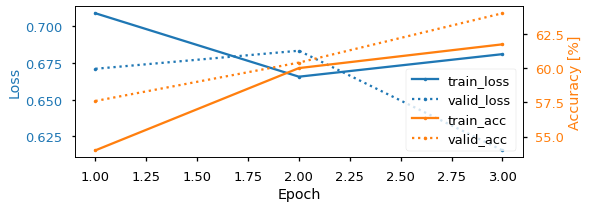

In [41]:
# PLOTS
# Extract loss and balanced accuracy values for plotting from history object

df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()

In [46]:
# CONFUSION MATRIX
# Switch to the test sampler

clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

IndexError: arrays used as indices must be of integer (or boolean) type

In [47]:
######################################################################
# Using the learned representation for sleep staging
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#

######################################################################
# We can now use the trained convolutional neural network as a feature
# extractor. We perform sleep stage classification from the learned feature
# representation using a linear logistic regression classifier.
#

from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [emb(batch_x.to(device)).cpu().numpy()
                 for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)

# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

######################################################################
# The balanced accuracy is much higher than chance-level (i.e., 20% for our
# 5-class classification problem). Finally, we perform a quick 2D visualization
# of the feature space using a PCA:
#


AttributeError: 'str' object has no attribute 'decode'

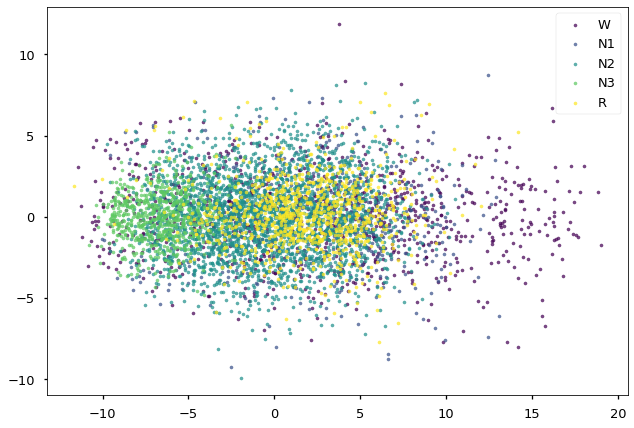

In [48]:

from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from matplotlib import cm

X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

pca = PCA(n_components=2)
# tsne = TSNE(n_components=2)
components = pca.fit_transform(X)

fig, ax = plt.subplots()
colors = cm.get_cmap('viridis', 5)(range(5))
for i, stage in enumerate(['W', 'N1', 'N2', 'N3', 'R']):
    mask = y == i
    ax.scatter(components[mask, 0], components[mask, 1], s=10, alpha=0.7,
               color=colors[i], label=stage)
ax.legend()


######################################################################
# We see that there is sleep stage-related structure in the embedding. A
# nonlinear projection method (e.g., tSNE, UMAP) might yield more insightful
# visualizations. Using a similar approach, the embedding space could also be
# explored with respect to subject-level features, e.g., age and sex.
#

######################################################################
# Conclusion
# ----------
#

######################################################################
# In this example, we used self-supervised learning (SSL) as a way to learn
# representations from unlabelled raw EEG data. Specifically, we used the
# relative positioning (RP) pretext task to train a feature extractor on a
# subset of the Sleep Physionet dataset. We then reused these features in a
# downstream sleep staging task. We achieved reasonable downstream performance
# and further showed with a 2D projection that the learned embedding space
# contained sleep-related structure.
#
# Many avenues could be taken to improve on these results. For instance, using
# the entire Sleep Physionet dataset or training on larger datasets should help
# the feature extractor learn better representations during the pretext task.
# Other SSL tasks such as those described in [1]_ could further help discover
# more powerful features.
#
#

---

## TEST AREA

---

In [13]:
def print_dataset_lengths(datasets):
    for data in datasets:
        print(type(data))
        try:
            for i in range(100):
                print(f"({i}) length: {len(data)}  | 1st value: {data[0]} | type: {type(data)}")
                data = data[0]
        except:
            print("------------------------------------------------------------------")

In [14]:
print_dataset_lengths([X.datasets, X])

<class 'list'>
(0) length: 1  | 1st value: <braindecode.datasets.base.BaseDataset object at 0x7fb0b1ac4220> | type: <class 'list'>
(1) length: 2508001  | 1st value: (array([[ 8.11135531e-06],
       [-1.69963370e-06]]), None) | type: <class 'braindecode.datasets.base.BaseDataset'>
(2) length: 2  | 1st value: [[ 8.11135531e-06]
 [-1.69963370e-06]] | type: <class 'tuple'>
(3) length: 2  | 1st value: [8.11135531e-06] | type: <class 'numpy.ndarray'>
(4) length: 1  | 1st value: 8.11135531135531e-06 | type: <class 'numpy.ndarray'>
------------------------------------------------------------------
<class 'braindecode.datasets.sleep_physionet.SleepPhysionet'>
(0) length: 2508001  | 1st value: (array([[ 8.11135531e-06],
       [-1.69963370e-06]]), None) | type: <class 'braindecode.datasets.sleep_physionet.SleepPhysionet'>
(1) length: 2  | 1st value: [[ 8.11135531e-06]
 [-1.69963370e-06]] | type: <class 'tuple'>
(2) length: 2  | 1st value: [8.11135531e-06] | type: <class 'numpy.ndarray'>
(3) len

In [15]:
# take only 1 3000ms window for both channels

window_index = 0

X = X_windowed.datasets[0][window_index][0]
X

Loading data for 1 events and 3000 original time points ...


array([[ 8.1113549e-06,  1.7488645e-05,  2.1239561e-05, ...,
        -1.0361905e-05, -1.1112088e-05, -2.1098901e-06],
       [-1.6996337e-06, -1.8915750e-06, -4.3868131e-06, ...,
         4.1172160e-07,  3.9626375e-06, -1.6036630e-06]], dtype=float32)

In [16]:
# from braindecode.datasets.mne import create_from_mne_raw


# # attempt custom input
# X = mne.io.read_raw_fif('sleep_staging_dataset/0-raw.fif', preload=True)
# mne.io.Raw.filter(X, l_freq=None,h_freq=30, n_jobs=n_jobs)

# # preprocessing
# # preprocessors = [
# #     Preprocessor(lambda x: x * 1e6),
#     # Preprocessor('filter', l_freq=None, h_freq=30, n_jobs=n_jobs)
# # ]
# # preprocess(dataset, preprocessors)




In [17]:

# mapping = {  # We merge stages 3 and 4 following AASM standards.
#     'Sleep stage W': 0,
#     'Sleep stage 1': 1,
#     'Sleep stage 2': 2,
#     'Sleep stage 3': 3,
#     'Sleep stage 4': 3,
#     'Sleep stage R': 4
# }

# # Create windows
# window_size_samples = window_size_s * sfreq

# # define windows
# X_windowed = create_from_mne_raw(
#     X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
#     window_size_samples=window_size_samples,
#     window_stride_samples=window_size_samples,
#     drop_last_window=True,
#     preload=True)

# # preprocess chanel-wise normalization
# # preprocess(windows_dataset, [Preprocessor(zscore)])

In [45]:
# dataset.datasets[0][3]

In [19]:
# transform to a tensor and unsqueeze it
tt = to_tensor(X, device).unsqueeze(0)

# print(tt.shape)
# print(tt)

In [20]:
# both channels
X_1 = X[0]
X_2 = X[1]

In [21]:
# Get embedder from model and return the features
_model = clf.module_.emb
_model

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=544, out_features=100, bias=True)
  )
)

In [22]:
_model.return_feats = False
tt_y = _model.forward(tt)
y = tt_y.flatten().detach().numpy()

In [23]:
_model.return_feats = True
tt_y_fr = _model.forward(tt)
y_fr = tt_y_fr.flatten().detach().numpy()

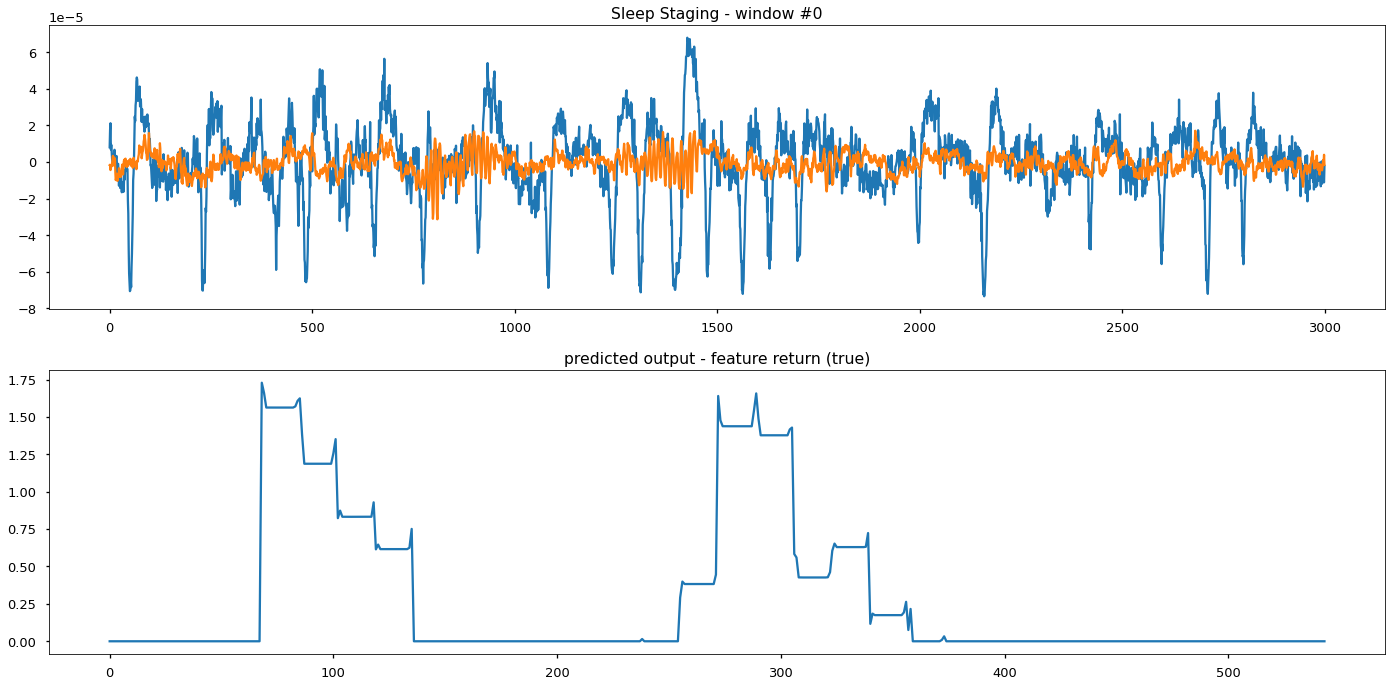

In [24]:
# plot channels, y, y_fr

fig, ax = plt.subplots(2, figsize=(20,10))
fig.tight_layout(pad=3)


# plot all channels in the same plot
ax[0].set_title(f'Sleep Staging - window #{window_index}')
[ax[0].plot(x) for x in X]

# ax[1].set_title('predicted output - feature return (false)')
# ax[1].plot(y)
ax[1].set_title('predicted output - feature return (true)')
ax[1].plot(y_fr)

# create dir if it doesn't exist
plot_dir = './prediction_feature_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

plt.savefig(f'{plot_dir}/predicted_window_{window_index}.png')
# plt.close()


/home/maligan/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


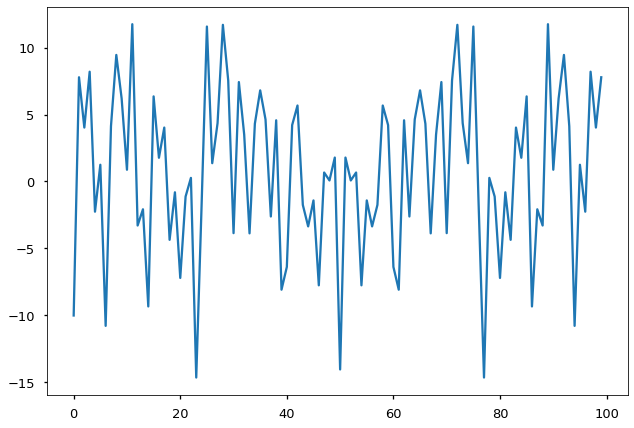

In [25]:
plt.plot(np.fft.fft(y))

/home/maligan/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


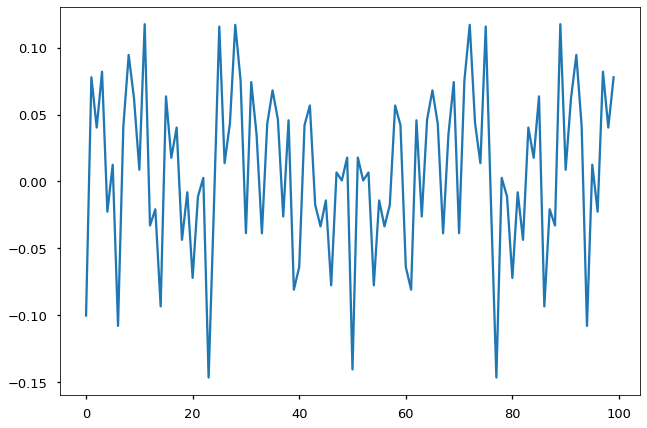

In [26]:
plt.plot(np.fft.ifft(y))

---
# Save output
---

In [27]:
### convert to csv for Robin's Viewer

import pandas as pd

# add time column
time = [x/100 for x in range(len(y))]
_y = np.expand_dims(y, 0)
_y = np.insert(_y, 0, time, axis=0)

df = pd.DataFrame(_y.T, columns=["Time", "model"]).set_index('Time')
df.to_csv("predictions_output.csv")

df

,model
Time,
0.00,0.746667
0.01,0.550017
0.02,0.478233
0.03,1.991937
0.04,0.466510
...,...
0.95,0.374333
0.96,-0.742410
0.97,0.385158
